## Python Symbolic Information Theoretic Inequality Prover -- Demo

In [1]:
from psitip import *
PsiOpts.setting(solver = "pyomo.glpk")  # Set linear programming solver
PsiOpts.setting(repr_latex = True)      # Turn on Jupyter Notebook LaTeX display
PsiOpts.setting(venn_latex = True)      # Turn on LaTeX in diagrams

X, Y, Z, W, U, M, S = rv("X, Y, Z, W, U, M, S") # Declare random variables

In [2]:
H(X+Y) - H(X) - H(Y)  # Simplify H(X,Y) - H(X) - H(Y)

-I(Y&X)

In [3]:
bool(H(X) + I(Y & Z | X) >= I(Y & Z))  # Check H(X) + I(Y;Z|X) >= I(Y;Z)

True

In [4]:
(markov(X+W, Y, Z) >> (I(X & W | Y) / 2 <= H(X | Z))).display_bool() # Implication

<IPython.core.display.Math object>

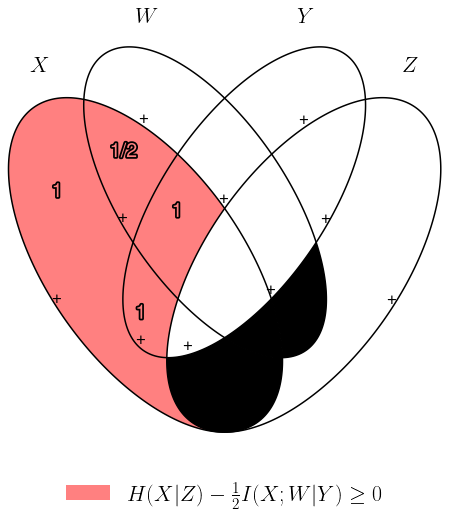

<Figure size 432x288 with 0 Axes>

In [5]:
# Information diagram that shows the above implication
(markov(X+W, Y, Z) >> (I(X & W | Y) / 2 <= H(X | Z))).venn()

In [6]:
# The condition "X is independent of Y and X-Y-Z forms a
# Markov chain" can be simplified to "X is independent of (Y,Z)"
markov(X, Y, Z) & indep(X, Y)

indep(X, Z+Y) 

In [7]:
# The condition "there exists Y independent of X such that 
# X-Y-Z forms a Markov chain" can be simplified to "X,Z independent"
(markov(X, Y, Z) & indep(X, Y)).exists(Y).simplified()

indep(X, Z) 

------
## User-defined information quantities

In [8]:
# Define Gács-Körner common information [Gács-Körner 1973]
gkci = ((H(U|X) == 0) & (H(U|Y) == 0)).maximum(H(U), U)

# Define Wyner's common information [Wyner 1975]
wci = markov(X, U, Y).minimum(I(U & X+Y), U)

# Define common entropy [Kumar-Li-El Gamal 2014]
eci = markov(X, U, Y).minimum(H(U), U)

In [9]:
(gkci <= I(X & Y)).display_bool()        # Gács-Körner <= I(X;Y)

<IPython.core.display.Math object>

In [10]:
(I(X & Y) <= wci).display_bool()         # I(X;Y) <= Wyner

<IPython.core.display.Math object>

In [11]:
(wci <= emin(H(X), H(Y))).display_bool() # Wyner <= min(H(X),H(Y))

<IPython.core.display.Math object>

In [12]:
# Automatically discover inequalities among quantities
universe().discover([X, Y, gkci, wci, eci])

( ( (( ( H(U|X) == 0 )
 &( H(U|Y) == 0 ) ).exists(U)).maximum(H(U)) >= 0 )
 &( (( ( markov(X, U, Y) ) ).exists(U)).minimum(I(U&X+Y)) <= (( ( markov(X, U, Y) ) ).exists(U)).minimum(H(U)) )
 &( (( ( markov(X, U, Y) ) ).exists(U)).minimum(H(U)) <= H(X) )
 &( (( ( markov(X, U, Y) ) ).exists(U)).minimum(H(U)) <= H(Y) )
 &( (( ( H(U|X) == 0 )
 &( H(U|Y) == 0 ) ).exists(U)).maximum(H(U)) <= I(X&Y) )
 &( I(X&Y) <= (( ( markov(X, U, Y) ) ).exists(U)).minimum(I(U&X+Y)) ) )

In [13]:
# The meet or Gács-Körner common part [Gács-Körner 1973] between X and Y
# is a function of the GK common part between X and (Y,Z)
(H(meet(X, Y) | meet(X, Y + Z)) == 0).display_bool()

<IPython.core.display.Math object>

------
## Automatic inner/outer bound for degraded broadcast channel

In [14]:
X, Y, Z = rv("X, Y, Z")
M1, M2 = rv_array("M", 1, 3)
R1, R2 = real_array("R", 1, 3)

model = CodingModel()
model.add_node(M1+M2, X)  # Encoder maps M1,M2 to X
model.add_edge(X, Y)      # Channel X -> Y -> Z
model.add_edge(Y, Z)
model.add_node(Y, M1)     # Decoder1 maps Y to M1
model.add_node(Z, M2)     # Decoder2 maps Z to M2
model.set_rate(M1, R1)    # Rate of M1 is R1
model.set_rate(M2, R2)    # Rate of M2 is R2

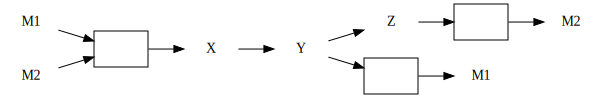

In [15]:
model.graph()             # Draw diagram

In [16]:
# Inner bound via [Lee-Chung 2015], give superposition region [Bergmans 1973], [Gallager 1974]
r = model.get_inner()
r

( ( R1 >= 0 )
 &( R2 >= 0 )
 &( R2 <= I(A_X_M2&Z) )
 &( R1+R2 <= I(A_X_M2&Z)+I(X&Y|A_X_M2) )
 &( markov(A_X_M2, X, Y, Z) ) ).exists(A_X_M2)

In [17]:
r.maximum(R1 + R2, [R1, R2])          # Max sum rate

(markov(Z, Y, X) ).maximum(I(X&Y))

In [18]:
r.maximum(emin(R1, R2), [R1, R2])     # Max symmetric rate

(( ( max94248(emin(R1, R2)) <= I(A_X_M2&Z) )
 &( 2*max94248(emin(R1, R2)) <= I(A_X_M2&Z)+I(X&Y|A_X_M2) )
 &( markov(A_X_M2, X, Y, Z) ) ).exists(A_X_M2)).maximum(max94248(emin(R1, R2)))

In [19]:
r.maximum(R1 / 2 + R2, [R1, R2])      # Max weighted sum rate

(( ( markov(A_X_M2, X, Y, Z) ) ).exists(A_X_M2)).maximum(I(A_X_M2&Z)+(1/2)*I(X&Y|A_X_M2))

In [20]:
r.exists(R1)   # Eliminate R1, same as r.projected(R2)

( ( R2 >= 0 )
 &( R2 <= I(X&Z) )
 &( markov(Z, Y, X) ) )

In [21]:
# Eliminate Z, i.e., taking union of the region over all choices of Z
# The program correctly deduces that it suffices to consider Z = Y
r.exists(Z).simplified()

( ( R1 >= 0 )
 &( R2 >= 0 )
 &( R1+R2 <= I(X&Y) ) )

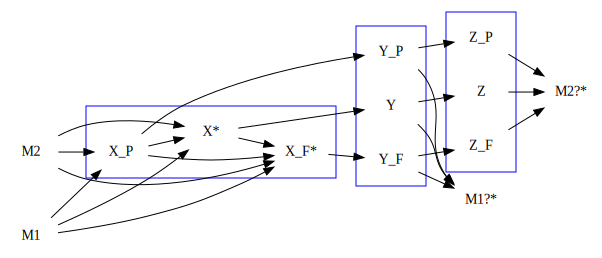

In [22]:
r_out = model.get_outer() # Automatic outer bound
model.graph_outer()       # Bayesian network of past/future variables

In [23]:
# Converse proof, print auxiliary random variables
CompArray((r_out >> r).check_getaux())

CompArray(
[[A_X_M2, Y_F+Z_P+Z_F+M2]])

------
## Non-Shannon-type Inequalities

In [24]:
# Zhang-Yeung inequality [Zhang-Yeung 1998] cannot be proved by Shannon-type inequalities
(2*I(Z&W) <= I(X&Y) + I(X & Z+W) + 3*I(Z&W | X) + I(Z&W | Y)).display_bool()

<IPython.core.display.Math object>

In [25]:
# Using copy lemma [Zhang-Yeung 1998], [Dougherty-Freiling-Zeger 2011]
with copylem().assumed():
    
    # Prove Zhang-Yeung inequality
    (2*I(Z&W) <= I(X&Y) + I(X & Z+W) + 3*I(Z&W | X) + I(Z&W | Y)).display_bool()

<IPython.core.display.Math object>

In [26]:
# State the copy lemma
r = eqdist([X, Y, U], [X, Y, Z]) & markov(Z+W, X+Y, U)

# Automatically discover non-Shannon-type inequalities using copy lemma
r.discover(mi_cells(X, Y, Z, W))

( ( 2*I(X&Y|Z+W)+I(X&Z|Y+W)+I(Y&Z|X+W)+I(Z&W|X+Y)+I(X&Y&W|Z)+2*I(X&Z&W|Y)+2*I(Y&Z&W|X) >= 0 )
 &( I(X&Y|Z+W)+2*I(X&Z|Y+W)+I(Y&Z|X+W)+I(Y&W|X+Z)+2*I(X&Y&W|Z)+I(X&Z&W|Y)+2*I(Y&Z&W|X) >= 0 )
 &( I(X&Y|Z+W)+I(X&Z|Y+W)+I(X&W|Y+Z)+2*I(Y&Z|X+W)+2*I(X&Y&W|Z)+2*I(X&Z&W|Y)+I(Y&Z&W|X) >= 0 ) )